# A small emergency

It's 10 in the morning and you're dipping our fresh croissants into a hot cappuccino, when an account manager runs to your desk. It seems like one of our big merchants, 'Not A Taxi Company LTD.', is having some troubles with processing payments from their customers, leading many of these customers to take the 'Not A Taxi', but accidentally not being charged.

For this question, **you'll need to know how the basic payment flow looks like**. 

So let me explain:

When a customer takes a 'Not A Taxi', they swipe their credit card on the on-board terminal. This terminal is connected to our system, which in turn is connected to the credit card companies. If you have enough money on your account, the payment is approved and you start your ride. This is the **authorization**. At this point the payment is 'Authorized'

The actual money is, however, collected a bit later - **usually a few hours**, but it could be up to 28 days! This step is called the **clearing**. Only after the money has actually been cleared, your bank pays us, and we pay it out to 'Not A Taxi Company LTD.' The payment becomes 'Cleared'. <br> If this doesn't work out, the payment is logged as 'Clearing failed'.

In this case, the authorization is succesful - and so the customer rides happily into the sunset. But, a few days later, the clearing has failed and 'Not A Taxi' still hasn't received their hard-earned money - because the payment never went from 'Authorized' to 'Cleared'! <br> Obviously, they angrily call the account manager demanding answers. And that's why your Cappuccino and Croissant moment is cut short: time to solve this problem!

## Here's your data

Look into the "data" folder we sent you. You'll find three files:

1. "_transactions.csv_" is a list of **all transactions 'Not A Taxi Company' processed through My_PSP last week.**. You'll need this for questions 1 and 2.
2. "_bintable.csv_" is an **outline of our BIN mapping**. But what is a BIN? Easy enough: the BIN are the **first six digits** of your card number. <br> A BIN table will therefore have informations about your card. It is very useful to debug what went wrong in the payment flow, without needing to know the entire card number. You'll need this for question 2.
3. "rates.csv" is a summary of the rates that our taxi companies pay per transaction. You'll need this for question 3

Finally, to give you a bit more context, let's look at bintable.csv, which you'll need for context as well as for question 2

In [1]:
import pandas as pd

pd.read_csv("data/bintable.csv").head(2)

,BIN,Product types,Scheme,Enrolled in Secure3D,Dual Branded
0,273209,"[""CP_Credit""]",ChinaPay,YES,NO
1,457469,"[""Viza_Super""]",VIZA,YES,NO


* **BIN**: the first six digits of the Card Number on a transactions level.
* **Product types**: a certain BIN can have multiple card products - indeed, some credit cards are 'Dual Branded', which means they could be processed as either of the Card products in the 'product types' list. This list is formatted in JSON.
* **Scheme**: this is the company that is processing the Card.
* **Enrolled in Secure3D**: some transactions can have an extra layer of security. For a Secure3D transactions to work, the BIN needs to be enrolled (YES) and the Secure3D authentication also needs to be Used at transactional level.
* **Dual Branded**: this is an indicator on whether this BIN has only one product type (NO) or multiple product types (YES).

let's look at transactions.csv, which you'll need for question 1 and 2

In [2]:
pd.read_csv("data/transactions.csv").head(1)

,Transaction ID,Card Number (obfuscated),Processed Card Scheme,Processed Card Product,Used Secure3D,Authorization time,Transaction amount,Status,Error Code
0,310136972,390894......5010,Masterkard,MK_Debit,NO,2019-01-01 17:16:49,192.76,Cleared,NaN


* **Transaction ID**: an unique identifier in our system for this transaction
* **Card Number (obfuscated)**: the first six and last four digits of a card number
* **Processed Card Scheme**: one of the many card providers mypsp works with
* **Processed Card Product**: Card schemes offer many products. This is the product that is associated with a given transaction
* **Used Secure3d**: whether the transaction used an extra layer of security
* **Transaction amount**: the price paid by the shopper to Not A Taxi Company LTD.
* **Status**: either 'Cleared' (OK), or 'Clearing_failed' (NOT OK!)
* **Error code**: A response from the Card Scheme when the status is 'Clearing_failed', which can help you pinpoint any issues

Finally, let's look at 'rates.csv', which you need for question 3:

In [3]:
pd.read_csv("data/rates.csv").head(1)

,Processed Card Product,Processed Card Scheme,Transaction amount,Rate percent,Rate amount
0,MK_Debit,Masterkard,451.68,0.5,2.3


You have the same columns as in transactions.csv, plus:
* **Rate percent**: the percentage amount that was paid to the Card Schemes. This is a cost for Not A Taxi Company LTD. The Card Schemes have various rates for different Card Products - and sometimes multiple rates for the same card product!.
* **Rate amount**: the corresponding fee in euro paid to the Card Schemes for the transactions. It's calculated as ```Transaction amount * Rate percent```

## Question 1: data-driven analysis

With this question, we want to see:
* how you cope with quick data analysis
* that you're able to quickly assess magnitude and scale of a given problem

**Please use the data provided to quantify the transactions we haven't correctly cleared for 'Not A Taxi Company LTD.' for the provided period. 
Is the problem getting better, or worse? _What is the impact?_**

This question should be a quick one: it's a preliminary analysis, so while accuracy is important, you should be more focused in seeing if this problem needs to be solved now, or can be postponed to later.

**Write a short e-mail to a colleague presenting the issue and why you'd need to act upon it, and find a solution - fast.**

## <font color='blue'> Question 1: Answer </font>

### <font color='blue'> Import necessary python libraries </font>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

### <font color='blue'> Extract the transactions data from the file </font>

Let's extract the transactional data from the transactions.csv file. The data will give us an idea about successful and failed cleared transactions and their details.

In [5]:
# Data from the transaction file
transactions_data = pd.read_csv(
    "data/transactions.csv", parse_dates=["Authorization time"]
)

# See the data frame
transactions_data.head(2)

,Transaction ID,Card Number (obfuscated),Processed Card Scheme,Processed Card Product,Used Secure3D,Authorization time,Transaction amount,Status,Error Code
0,310136972,390894......5010,Masterkard,MK_Debit,NO,2019-01-01 17:16:49,192.76,Cleared,NaN
1,314127106,236786......444,ChinaPay,CP_Debit,YES,2019-01-05 22:08:46,230.36,Cleared,NaN


In [6]:
# Datatypes of the columns
transactions_data.dtypes

Transaction ID                       int64
Card Number (obfuscated)            object
Processed Card Scheme               object
Processed Card Product              object
Used Secure3D                       object
Authorization time          datetime64[ns]
Transaction amount                 float64
Status                              object
Error Code                          object
dtype: object

In [7]:
# Check the completeness of the data (Data sanity)
transactions_data.isnull().sum()

Transaction ID                   0
Card Number (obfuscated)         0
Processed Card Scheme            0
Processed Card Product           0
Used Secure3D                    0
Authorization time               0
Transaction amount               0
Status                           0
Error Code                  101000
dtype: int64

NOTE: The NaN/Null values in the 'Error Code' field corresponds to the transactions that are successful. Hence there is no error in the process.

### <font color='blue'> Feature extraction </font>

We can extract few new features such as 'Authorization day' and 'BIN' from existing features. These new features will be very useful for future analysis.

In [8]:
# Create a new column for authorization day
transactions_data["Authorization day"] = transactions_data["Authorization time"].dt.day

# Create a new column for BIN
transactions_data["BIN"] = (
    transactions_data["Card Number (obfuscated)"].str.slice(0, 6).astype(int)
)

transactions_data.head()

,Transaction ID,Card Number (obfuscated),Processed Card Scheme,Processed Card Product,Used Secure3D,Authorization time,Transaction amount,Status,Error Code,Authorization day,BIN
0,310136972,390894......5010,Masterkard,MK_Debit,NO,2019-01-01 17:16:49,192.76,Cleared,NaN,1,390894
1,314127106,236786......444,ChinaPay,CP_Debit,YES,2019-01-05 22:08:46,230.36,Cleared,NaN,5,236786
2,316026078,233199......8244,ChinaPay,CP_QR,YES,2019-01-07 22:33:51,306.97,Clearing_failed,CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME,7,233199
3,318604383,550282......6368,Masterkard,MK_Credit,NO,2019-01-10 16:02:31,365.75,Cleared,NaN,10,550282
4,314205307,425306......393,VIZA,VIZA_Debit,YES,2019-01-06 00:11:14,578.66,Clearing_failed,VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_...,6,425306


### <font color='blue'> Assess magnitude and scale of the given problem </font>

During this analysis, we will mainly focus on below aspects.

* How many transactions failed during the clearing process? (Number and percentage)
* How much money has been unaccounted or lost due to the failed clearing process? (Amount and percentage)

In [9]:
print(
    "Number (#) of failed clearing transactions = ",
    sum(transactions_data["Status"] == "Clearing_failed"),
)

print(
    "Percentage (%) of failed clearing transactions = ",
    round(
        sum(transactions_data["Status"] == "Clearing_failed")
        / transactions_data.shape[0]
        * 100,
        2,
    ),
)

print(
    "Amount (#) of unaccounted money from failed clearing transactions in Euros = ",
    round(
        sum(
            transactions_data[transactions_data.Status == "Clearing_failed"][
                "Transaction amount"
            ]
        ),
        2,
    ),
)

print(
    "Percentage (%) of unaccounted money due to failed clearing transactions = ",
    round(
        sum(
            transactions_data[transactions_data.Status == "Clearing_failed"][
                "Transaction amount"
            ]
        )
        / sum(transactions_data["Transaction amount"])
        * 100,
        2,
    ),
)

Number (#) of failed clearing transactions =  9000
Percentage (%) of failed clearing transactions =  8.18
Amount (#) of unaccounted money from failed clearing transactions in Euros =  2536999.14
Percentage (%) of unaccounted money due to failed clearing transactions =  11.58


In [10]:
transactions_data.shape[0]

110000

### <font color='blue'> Remove partially captured data from different days </font>

In [12]:
print("Earliest transaction time =  ", transactions_data["Authorization time"].min())
print("Latest transaction time =  ", transactions_data["Authorization time"].max())

Earliest transaction time =   2019-01-01 13:44:02
Latest transaction time =   2019-01-12 03:32:10


NOTE: Looking the timestamps of the earliest and latest transaction authorization time, it seems that full day data hasn't been captured on '2019-01-01' and on '2019-01-12'. This might incorrectly show the day wise comparison/progress of monetary losses and number of failed clearing transactions. In order to come up with unbiased or incorrect judgement, we can exclude transactions on these two days from our data.

In [13]:
# Create a new dataframe which doesn't contain the transactions from earliest and the latest transaction days
transactions_data_cleaned = transactions_data[
    (transactions_data["Authorization day"] != 1)
    & (transactions_data["Authorization day"] != 12)
]

print(
    "Earliest transaction time (cleaned data) =  ",
    transactions_data_cleaned["Authorization time"].min(),
)
print(
    "Latest transaction time (cleaned data) =  ",
    transactions_data_cleaned["Authorization time"].max(),
)

Earliest transaction time (cleaned data) =   2019-01-02 00:00:13
Latest transaction time (cleaned data) =   2019-01-11 23:59:39


### <font color='blue'> Is the problem getting better, or worse? What is the impact? </font>

In this analysis, we want to see if this problem is getting better or worse day by day. We can do this by comparing the number of failed clearing transactions and respective monetary losses on a day to day basis.

Visualization (Scattered plot or Bar plot) would be nice have.

In [14]:
# Group by 'Authorization day' to calculate number of failed clearning transaction and respective monetary losses (per day)
per_day_failure_statistics = (
    transactions_data_cleaned[transactions_data_cleaned.Status == "Clearing_failed"]
    .groupby("Authorization day")
    .agg({"Status": "count", "Transaction amount": "sum"})
)

# Reset the index to have the 'Authorization day' as a column
per_day_failure_statistics.reset_index(inplace=True)

# Rename the column Status to Count
per_day_failure_statistics.rename(
    columns={
        "Status": "Failed transactions count",
        "Transaction amount": "Uncleared transaction amount",
    },
    inplace=True,
)

per_day_failure_statistics

,Authorization day,Failed transactions count,Uncleared transaction amount
0,2,344,147468.76
1,3,316,134170.90
2,4,808,233334.06
3,5,869,246702.68
4,6,855,255950.65
5,7,1130,289921.34
6,8,1118,288918.89
7,9,1121,302233.13
8,10,1115,290613.00
9,11,1165,305794.84


Looking at the above numbers, it seems that the number of failed clearing transactions and sum of respective transaction amount are growing day by day. Things are getting worse here. Let's apply some visualization.

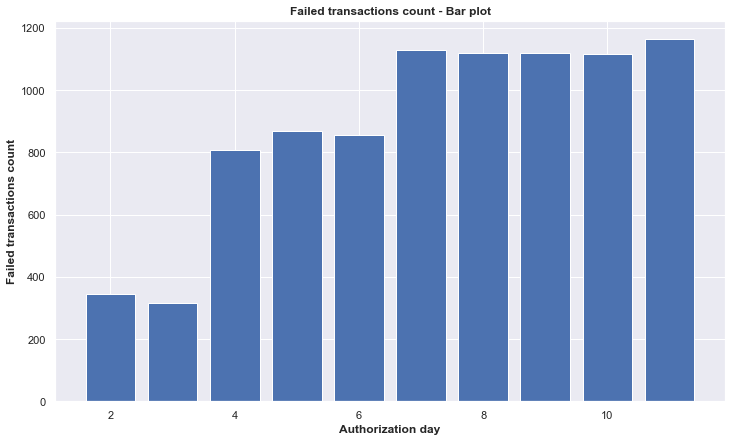

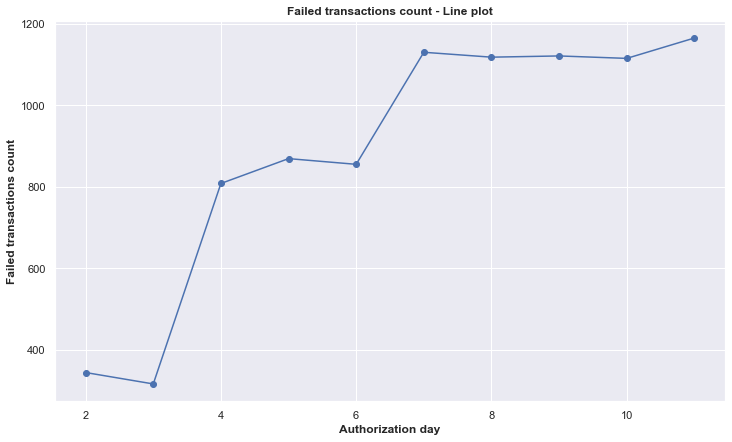

In [15]:
# Failed transactions count per day - Bar plot
plt.figure(figsize=(12,7))
plt.bar(
    per_day_failure_statistics["Authorization day"],
    per_day_failure_statistics["Failed transactions count"],
)
plt.title("Failed transactions count - Bar plot", fontweight='bold')
plt.xlabel("Authorization day", fontweight='bold')
plt.ylabel("Failed transactions count", fontweight='bold')
plt.show()

# Failed transactions count per day - Line plot
plt.figure(figsize=(12,7))
plt.plot(
    per_day_failure_statistics["Authorization day"],
    per_day_failure_statistics["Failed transactions count"],
    linestyle="-",
    marker="o",
)
plt.title("Failed transactions count - Line plot", fontweight='bold')
plt.xlabel("Authorization day", fontweight='bold')
plt.ylabel("Failed transactions count", fontweight='bold')
plt.show()

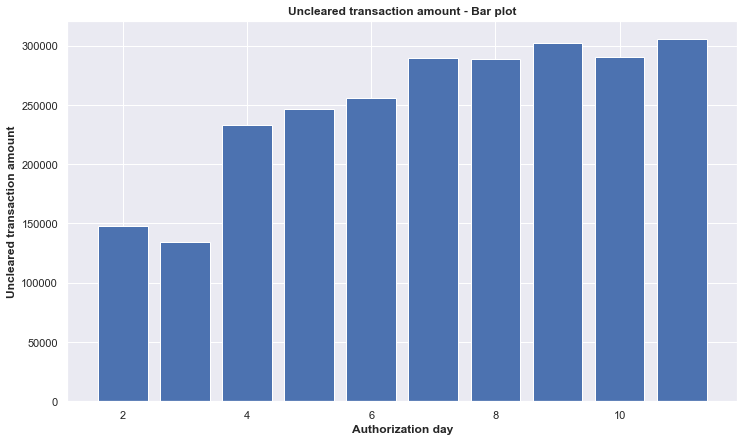

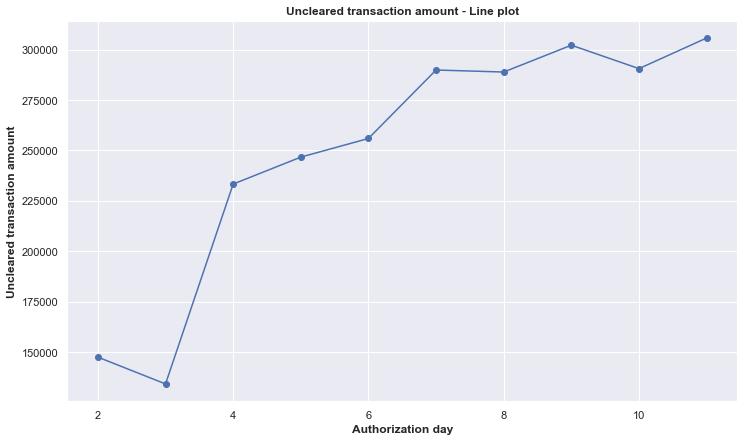

In [16]:
# Uncleared transaction amount per day - Bar plot
plt.figure(figsize=(12,7))
plt.bar(
    per_day_failure_statistics["Authorization day"],
    per_day_failure_statistics["Uncleared transaction amount"],
)
plt.title("Uncleared transaction amount - Bar plot", fontweight='bold')
plt.xlabel("Authorization day", fontweight='bold')
plt.ylabel("Uncleared transaction amount", fontweight='bold')
plt.show()

# Uncleared transaction amount per day - Line plot
plt.figure(figsize=(12,7))
plt.plot(
    per_day_failure_statistics["Authorization day"],
    per_day_failure_statistics["Uncleared transaction amount"],
    linestyle="-",
    marker="o",
)
plt.title("Uncleared transaction amount - Line plot", fontweight='bold')
plt.xlabel("Authorization day", fontweight='bold')
plt.ylabel("Uncleared transaction amount", fontweight='bold')
plt.show()

## Question 2: advanced slicing and dicing of your data

With this question, we want to see:
* what your thinking is when tackling large datasets and new problems
* that you're able to identify and isolate root causes based on general information
* that you don't panic when presented with relatively large amounts of new data
* that you can formulate and test hypotheses

**Please use the data provided to find all the possible reason(s) why a number of transactions are stuck on 'Clearing failed'.**

This question is the most technically involved of the four. Note that there could be more reasons leading to a Clearing fail on the Not A Taxi LTD. account (however, a clearing file will generally be due to a single reason)

Luckily you get a column **Error code** in your transactions.csv dataset which might help you in pinpoint the root cause. **Do take advantage of that!**

You'll also need to use the **information contained in bintable.csv** to solve this question.

**Present the findings in the format you prefer to the account manager** 

## <font color='blue'> Question 2: Answer </font>

This question deals a lot with the 'Error Code'. This code might give an idea about why the clearing process failed for certain transaction. So let's see what are possible ways the clearing can fail.

In [17]:
print(transactions_data["Error Code"].unique())

[nan 'CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME'
 'VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_ENROLLED_BUT_USED'
 'MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND']


These error codes seem quite self-explanatory. For e.g.

CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME --> Probably says that there is some problem when using a card to do a transaction with amount that is too high (given the card profile).

VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_ENROLLED_BUT_USED --> Probably says that there is some problem when applying the 3DS authentication with the card (during payment processing), but 3DS is not enrolled for the card.

MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND --> Probably says that there is some problem when doing transaction with the card schemes that have with multiple products associated.

It would be best to investigate each problem separately. So let's divide & conquer.

### <font color='blue'> Error type 1: CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME </font>

Let's check and see the unique card schemes

In [18]:
card_schemes = transactions_data["Processed Card Scheme"].unique()
card_schemes

array(['Masterkard', 'ChinaPay', 'VIZA', 'Carte Rouge'], dtype=object)

Let's check and see for which Card Schemes this error 'CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME' is happening the most.

In [19]:
print(
    "Total number of Type 1 error = ",
    transactions_data[
        transactions_data["Error Code"] == "CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME"
    ].shape[0],
)

# Statistics of Type 1 error per card scheme
error_1_card_scheme = (
    transactions_data[
        transactions_data["Error Code"] == "CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME"
    ]
    .groupby("Processed Card Scheme")
    .agg({"Status": "count"})
)

# Reset the index to have the 'Processed Card Scheme' as a column
error_1_card_scheme.reset_index(inplace=True)

# Rename the column Status to Count
error_1_card_scheme.rename(
    columns={"Status": "Type 1 Failed transactions count"}, inplace=True
)

error_1_card_scheme

Total number of Type 1 error =  3330


,Processed Card Scheme,Type 1 Failed transactions count
0,ChinaPay,3330


Bammmmm. All the type 1 errors happed with Card Scheme 'ChinaPay'. Let's now dig deep on 'ChinaPay' to see the how the distribution of the 'Transaction amount' looks like for successful and failed transactions.

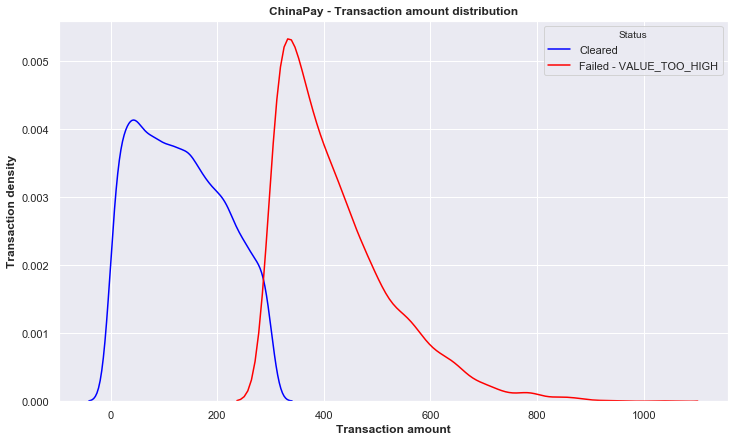

In [20]:
plt.figure(figsize=(12,7))
sns.distplot(
    transactions_data[
        (transactions_data["Status"] == "Cleared")
        & (transactions_data["Processed Card Scheme"] == "ChinaPay")
    ]["Transaction amount"],
    hist=False,
    kde=True,
    bins=50,
    color="blue",
    hist_kws={"edgecolor": "black"},
    label="Cleared",
)

sns.distplot(
    transactions_data[
        (transactions_data["Error Code"] == "CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME")
        & (transactions_data["Processed Card Scheme"] == "ChinaPay")
    ]["Transaction amount"],
    hist=False,
    kde=True,
    bins=50,
    color="red",
    hist_kws={"edgecolor": "black"},
    label="Failed - VALUE_TOO_HIGH",
)

# Plot formatting
plt.legend(title="Status")
plt.title("ChinaPay - Transaction amount distribution", fontweight='bold')
plt.xlabel("Transaction amount", fontweight='bold')
plt.ylabel("Transaction density", fontweight='bold')
plt.show()

From the above density plot, we see that majority of the failed transaction from 'ÇhinaPay' scheme have transaction amount much higher than those of successful transactions.

We can get make a comparison of median (to mitigate skewed distribution) transaction amount from successful and failed transactions.

Median transaction amount for successful transaction =  126.43  for failed transaction =  393.4


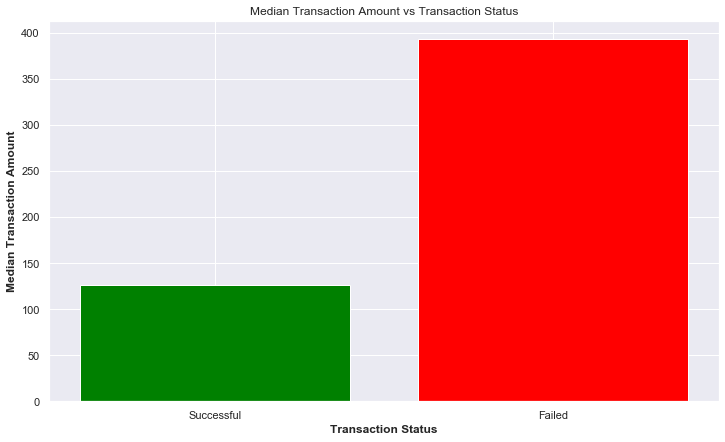

In [21]:
median_amount_successful = round(
    transactions_data[
        (transactions_data["Status"] == "Cleared")
        & (transactions_data["Processed Card Scheme"] == "ChinaPay")
    ]["Transaction amount"].median(),
    2,
)

median_amount_failed = round(
    transactions_data[
        (transactions_data["Error Code"] == "CP_98_TX_VALUE_TOO_HIGH_FOR_CARD_SCHEME")
        & (transactions_data["Processed Card Scheme"] == "ChinaPay")
    ]["Transaction amount"].median(),
    2,
)

print(
    "Median transaction amount for successful transaction = ",
    median_amount_successful,
    " for failed transaction = ",
    median_amount_failed,
)

status = np.arange(len(("Successful", "Failed")))
amount = [median_amount_successful, median_amount_failed]

plt.figure(figsize=(12,7))
plt.bar(status, amount, align="center", color=("green", "red"))
plt.xticks(status, ("Successful", "Failed"))
plt.xlabel("Transaction Status", fontweight='bold')
plt.ylabel("Median Transaction Amount", fontweight='bold')
plt.title("Median Transaction Amount vs Transaction Status")

plt.show()

Conclusion: 
* This error happened only for 'ChinaPay'.
* This error happens when the transaction amount is much higher than the usual (or permissible) transaction amount threshold.

### <font color='blue'> Error type 2: VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_ENROLLED_BUT_USED </font>

In order to investigate this type 2 error, we need to know whether a certain card scheme is enrolled for 3DS authentication. We have this information in the 'bintable.csv' file. So let's extract the data from this file.

In [22]:
# Read the data from the bintable file
bin_data = pd.read_csv("data/bintable.csv")

# See the data frame
bin_data.head(2)

,BIN,Product types,Scheme,Enrolled in Secure3D,Dual Branded
0,273209,"[""CP_Credit""]",ChinaPay,YES,NO
1,457469,"[""Viza_Super""]",VIZA,YES,NO


Let's join the bin data with the transaction data to see the transactions (on card schemes) for which 3DS authentication is not enrolled but used during the payment processing.

In [23]:
# Merge the transaction data and the BIN data
transactions_bin_data = transactions_data.merge(
    bin_data, how="inner", left_on="BIN", right_on="BIN"
)

# Remove duplicate columns
transactions_bin_data.drop(["Scheme"], axis=1, inplace=True)

# Show the data
transactions_bin_data.head(2)

,Transaction ID,Card Number (obfuscated),Processed Card Scheme,Processed Card Product,Used Secure3D,Authorization time,Transaction amount,Status,Error Code,Authorization day,BIN,Product types,Enrolled in Secure3D,Dual Branded
0,310136972,390894......5010,Masterkard,MK_Debit,NO,2019-01-01 17:16:49,192.76,Cleared,NaN,1,390894,"[""MK_Debit""]",NO,NO
1,314536287,390894......1946,Masterkard,MK_Debit,YES,2019-01-06 08:40:28,516.61,Cleared,NaN,6,390894,"[""MK_Debit""]",NO,NO


In [24]:
print(
    "Total number of Type 2 error = ",
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_ENROLLED_BUT_USED"
    ].shape[0],
)

# Statistics of Type 2 error in the context of 3DS enrollment and usage
error_2_3DS_enroll_usage = (
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_ENROLLED_BUT_USED"
    ]
    .groupby(["Used Secure3D", "Enrolled in Secure3D"])
    .agg({"Status": "count"})
)

# Reset the index to have the "Used Secure3D" and "Enrolled in Secure3D" as columns
error_2_3DS_enroll_usage.reset_index(inplace=True)

# Rename the column Status to Count
error_2_3DS_enroll_usage.rename(
    columns={"Status": "Type 2 Failed transactions count"}, inplace=True
)

error_2_3DS_enroll_usage

Total number of Type 2 error =  4266


,Used Secure3D,Enrolled in Secure3D,Type 2 Failed transactions count
0,YES,NO,4266


Bammmmm. All the type 2 errors happened for cards (belonging to a particular card scheme and product), which are not enrolled for 3DS but used during payment processing. Let's now dig deep to see on which card schemes and on which card products this error happened the most.

In [25]:
# Statistics of Type 2 error in the context of 3DS enrollment and usage
error_2_3DS_card_scheme_product = (
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "VI_85_PROCESSING_SECURE_3DTRANSACTION_WAS_NOT_ENROLLED_BUT_USED"
    ]
    .groupby(["Processed Card Scheme", "Processed Card Product"])
    .agg({"Status": "count"})
)

# Reset the index to have the "Processed Card Scheme" and "Processed Card Product" as columns
error_2_3DS_card_scheme_product.reset_index(inplace=True)

# Rename the column Status to Count
error_2_3DS_card_scheme_product.rename(
    columns={"Status": "Type 2 Failed transactions count"}, inplace=True
)

error_2_3DS_card_scheme_product

,Processed Card Scheme,Processed Card Product,Type 2 Failed transactions count
0,VIZA,VIZA_Debit,790
1,VIZA,Viza_Credit,1490
2,VIZA,Viza_Pay,834
3,VIZA,Viza_Super,1152


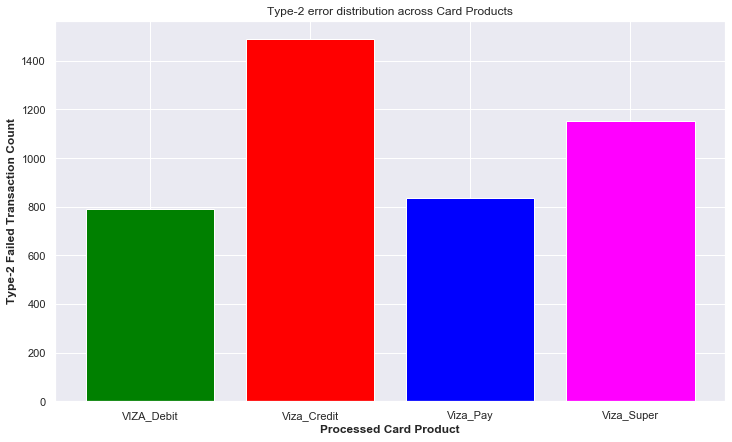

In [26]:
# Visualize the count through Bar plot
plt.figure(figsize=(12,7))
plt.bar(error_2_3DS_card_scheme_product["Processed Card Product"], error_2_3DS_card_scheme_product["Type 2 Failed transactions count"], color = ("green", "red", "blue", "magenta"))
plt.xlabel("Processed Card Product", fontweight='bold')
plt.ylabel("Type-2 Failed Transaction Count", fontweight='bold')
plt.title("Type-2 error distribution across Card Products")
plt.show()

Conclusion:
* This error happened on all the products from the card scheme 'VIZA'.
* This error happens when a BIN (representing a particular card scheme and card product) has not enrolled for 3DS authentication, but has used 3DS authentication while payment processing. 

### <font color='blue'> Error type 3: MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND </font>

To investigate this type 3 error, we have to focus on the dual branding property of the card. So let's check and confirm that this type 3 error happens only for cards (BINs) that have a dual branding property.

In [27]:
print(
    "Total number of Type 3 error = ",
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND"
    ].shape[0],
)

# Statistics of Type 3 error in the context of Dual branding
error_3_dual_branding = (
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND"
    ]
    .groupby("Dual Branded")
    .agg({"Status": "count"})
)

# Reset the index to have the "Dual Branded" as a column
error_3_dual_branding.reset_index(inplace=True)

# Rename the column Status to Count
error_3_dual_branding.rename(
    columns={"Status": "Type 3 Failed transactions count"}, inplace=True
)

error_3_dual_branding

Total number of Type 3 error =  1404


,Dual Branded,Type 3 Failed transactions count
0,YES,1404


Indeed!!!! This type 3 happened for cards corresponding to BINs that have a dual branding property associated. Let's now investigate for which card scheme and card product this error happens the most.

In [28]:
# Statistics of Type 3 error in the context of Card scheme and card product
error_3_card_scheme_product = (
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND"
    ]
    .groupby(["Processed Card Scheme", "Processed Card Product"])
    .agg({"Status": "count"})
)

# Reset the index to have the "Dual Branded" as a column
error_3_card_scheme_product.reset_index(inplace=True)

# Rename the column Status to Count
error_3_card_scheme_product.rename(
    columns={"Status": "Type 3 Failed transactions count"}, inplace=True
)

error_3_card_scheme_product

,Processed Card Scheme,Processed Card Product,Type 3 Failed transactions count
0,Masterkard,Mastro,1404


Bammmm!!! This type 3 error happened on card scheme 'Masterkard' and product 'Mastro'. Let's look at the associated BINs and associated dual branding card product.

In [29]:
# Statistics of Type 3 error in the context of multiple card products
error_3_card_products = (
    transactions_bin_data[
        transactions_bin_data["Error Code"]
        == "MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND"
    ]
    .groupby("Product types")
    .agg({"Status": "count"})
)

# Reset the index to have the "Dual Branded" as a column
error_3_card_products.reset_index(inplace=True)

# Rename the column Status to Count
error_3_card_products.rename(
    columns={"Status": "Type 3 Failed transactions count"}, inplace=True
)

error_3_card_products

,Product types,Type 3 Failed transactions count
0,"[""MK_Credit"", ""Mastro""]",233
1,"[""MK_Debit"", ""Mastro""]",228
2,"[""MK_Student"", ""Mastro""]",120
3,"[""Mastro"", ""MK_Credit""]",210
4,"[""Mastro"", ""MK_Debit""]",335
5,"[""Mastro"", ""MK_Student""]",278


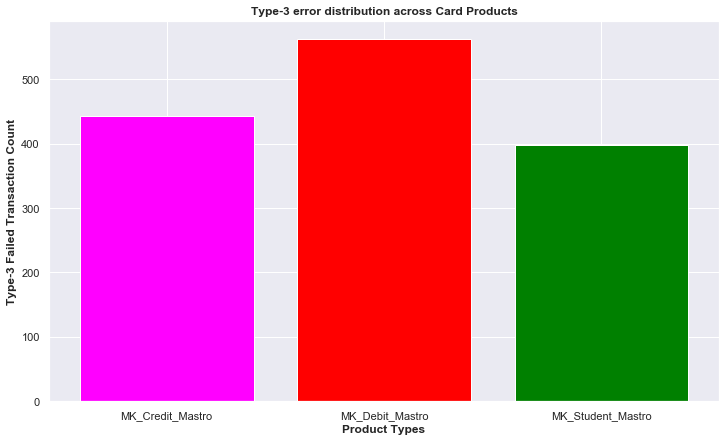

In [30]:
product_type_combinations = ["MK_Credit_Mastro", "MK_Debit_Mastro", "MK_Student_Mastro"]
type3_failed_transactions_count = [233+210, 228+335, 120+278]

# Visualize the count through Bar plot
plt.figure(figsize=(12,7))
plt.bar(product_type_combinations, type3_failed_transactions_count, align="center", color = ("magenta", "red", "green"))
plt.xlabel("Product Types", fontweight='bold')
plt.ylabel("Type-3 Failed Transaction Count", fontweight='bold')
plt.title("Type-3 error distribution across Card Products", fontweight='bold')
plt.show()

In [31]:
# Statistics of Type 3 error in the context of 3DS
error_3_3DS = transactions_bin_data[transactions_bin_data["Error Code"] == "MKMK_41_IMPOSSIBLE_TO_PROCESS_DUAL_BRAND_FOR_CARD_PRODUCT_BRAND"].groupby("Enrolled in Secure3D").agg({"Status": "count"})

# Reset the index to have the "Enrolled in Secure3D" as a column
error_3_3DS.reset_index(inplace=True)

# Rename the column Status to Count
error_3_3DS.rename(columns={"Status": "Type 3 Failed transactions count"}, inplace=True)

error_3_3DS

,Enrolled in Secure3D,Type 3 Failed transactions count
0,NO,1404


Conclusion:
* This error only happened on the cards (corresponding to BINs) that have dual branding property associated.
* This error only happened on card scheme 'Masterkard' for the product 'Mastro'. This product 'Mastro' can be associated with 'MK_Credit', 'MK_Debit' and 'MK_Student' products in a specific BIN.
* This error only happened on card products that are not enrolled for 3DS.

# A great opportunity

You have now solved the problem for 'Not A Taxi LTD' so brilliantly, that word got out that MyPSP is the best company in class when providing solutions to taxi companies.

Taxily, a new taxi prospect, has approached our sales team with a question about how much it would cost them to move from our current provider to MyPSP's proposition.

You have downloaded 'rates.csv' from our server, which provides a sample of transactions over a short period.

The bottom line is that a certain percentage of any card transaction is paid out to the Schemes and the Issuing banks (this is a very complicated system, but let's keep it simple for now). This is the **rate**. 

For instance, let's say you took a taxi from Amsterdam to Eindhoven airport, and you paid 100 EUR for the ride. Depending on the card you used, your rate could be anything between 0.20% and 4% of the transaction amount: that means that between 0.20 and 4 EUR of that 100 EUR ride are paid out to your bank and the Card Scheme, instead of to the taxi company.

Obviously, our customers want to estimate and reduce this cost as much as possible, which is where you come in.

## Question 3: estimation

With this question we want to see:

* If you're able to quickly estimate aggregate numbers from raw data
* If you can apply basic concepts to obtain ballpark estimates.

You receive the following e-mail from the Sales Manager

```
Hey man, 
Taxily, our new potential customer, processed 94843723 EUR in rides last month.

They have told me:
- that 40% of their traffic is on VIZA cards
- they also have 35% of traffic on Masterkard cards
- finally, they have 25 % of traffic on ChinaPay

They don't accept special products such as VIZA PAY or Mastro yet. They only accept debit and credit products from Masterkard, VIZA and ChinaPay, as follows:
- 60% of their traffic is on debit cards
- 40% of their traffic is on credit cards

In their current solution (our competitors!), they pay 3% flat per transaction. So they spend 2.845.311,69 EUR a month currently. 

How much could they save by moving to MyPSP?
```

**Please answer with a short e-mail to the Sales Manager**

You can find a list of average rates per product in the rates.csv database, which will help with your estimation.

Please remember the average rate is espressed as **Rate percent**, hence, a 0,50 rate is actually 0,50%, or 50 BPS!
Applying a 0,50 rate percent on a 100 EUR transaction would, for instance, give a **Rate amount** of ```100*0,01*0,50 = 0,5```


## <font color='blue'> Question 3: Answer </font>

To answer this, we need rates data that is present in 'rates.csv' file. Let's extract data from that file.

In [32]:
# Read the data from the rates file
rates_data = pd.read_csv("data/rates.csv")

# See the data frame
rates_data.head(2)

,Processed Card Product,Processed Card Scheme,Transaction amount,Rate percent,Rate amount
0,MK_Debit,Masterkard,451.68,0.5,2.3
1,Carte_Rouge_Unique,Carte Rouge,375.70,0.9,3.4


We understood that 'Taxily', the future prospect is currently paying flat 3% of its transaction fees as commission to card schemes and issuing banks. This is irrespective of the card scheme or even card product used during the payment.

However, that's not the case with MyPSP. MyPSP charges different rates for different card schemes and even for different card products. Even sometime rates can differ for a particular card product (e.g. "MK_Debit") depending on various factors.

So to make things simple but still maintaining higher granularity, let's see what is the average rates for different card schemes and card products.

As 'Taxily' only gets traffic from card schemes ('VIZA', 'Masterkard' and 'ChinaPay'), and card products that are only 'Debit' and 'Credit' card, we will only take such schemes and products into consideration.

In [33]:
applicable_rates_data = rates_data[
    (rates_data["Processed Card Scheme"].isin(["Masterkard", "ChinaPay", "VIZA"]))
    & (
        rates_data["Processed Card Product"].isin(
            [
                "MK_Debit",
                "MK_Credit",
                "CP_Debit",
                "CP_Credit",
                "VIZA_Debit",
                "Viza_Credit",
            ]
        )
    )
]

applicable_rates_data.head(2)

,Processed Card Product,Processed Card Scheme,Transaction amount,Rate percent,Rate amount
0,MK_Debit,Masterkard,451.68,0.5,2.3
5,MK_Credit,Masterkard,202.72,1.5,3.0


Now let's calculate the average rates for the appropriate card products (Most granular entity).

In [34]:
# Statistics of average rates for various card products
rates_card_products = applicable_rates_data.groupby(["Processed Card Product"]).agg(
    {"Rate percent": "mean"}
)

# Reset the index to have the "Processed Card Product" as a column
rates_card_products.reset_index(inplace=True)

# Rename the column 'Rate percent' to 'Mean Rate percent'
rates_card_products.rename(columns={"Rate percent": "Mean Rate percent"}, inplace=True)

rates_card_products

,Processed Card Product,Mean Rate percent
0,CP_Credit,1.298111
1,CP_Debit,0.522029
2,MK_Credit,1.364686
3,MK_Debit,0.451272
4,VIZA_Debit,0.699070
5,Viza_Credit,0.928691


In [35]:
card_products = rates_card_products["Processed Card Product"].unique()
total_processed_amount = 94843723
prev_total_processing_fee = 2845311.69
prev_flat_rate = 3
prev_processing_fee_card_product_list = []
mypsp_total_processing_fee = 0
mypsp_processing_fee_card_product_list = []
mypsp_saving_percent_card_product_list = []

for card_product in card_products:
    # traffic distribution based on credit and debit card
    if "Credit" in card_product:
        percentage_traffic = 0.4
    else:
        percentage_traffic = 0.6

    # further traffic distribution based on VIZA, Masterkard and ChinaPay
    if "CP" in card_product:
        percentage_traffic = percentage_traffic * 0.25
    elif "MK" in card_product:
        percentage_traffic = percentage_traffic * 0.35
    else:
        percentage_traffic = percentage_traffic * 0.40

    # Net percentage traffic per card product
    percentage_traffic = round(percentage_traffic, 2)
    
    # mypsp averate rate per card product
    mypsp_rate = rates_card_products[
        rates_card_products["Processed Card Product"] == card_product
    ]["Mean Rate percent"].values[0]

    # Prev processing fee per card product based on flat commission rate
    prev_processing_fee_card_product = round(total_processed_amount * percentage_traffic * prev_flat_rate / 100, 2)
    
    # Add the prev processing few per card product to the list
    prev_processing_fee_card_product_list.append(prev_processing_fee_card_product)
    
    # mypsp processing fee per card product
    mypsp_processing_fee_card_product = round(total_processed_amount * percentage_traffic * mypsp_rate / 100, 2)
    
    # What percentage of prev processing fee mypsp is now saving
    mypsp_saving_percent_card_product_list.append(round((prev_processing_fee_card_product - mypsp_processing_fee_card_product)/prev_processing_fee_card_product * 100, 1))
    
    # Add the mypsp processing few per card product to the list
    mypsp_processing_fee_card_product_list.append(mypsp_processing_fee_card_product)
    
    # mypsp total processing fee
    mypsp_total_processing_fee = round(
        mypsp_total_processing_fee + mypsp_processing_fee_card_product, 2
    )

print(
    "Approximate processing fee that mypsp can charge (euros) = ", mypsp_total_processing_fee
)
print(
    "Approximate saving that Taxily can make by moving to mypsp (euros) = ",
    round(prev_total_processing_fee - mypsp_total_processing_fee, 2),
)

Approximate processing fee that mypsp can charge (euros) =  768524.35
Approximate saving that Taxily can make by moving to mypsp (euros) =  2076787.34


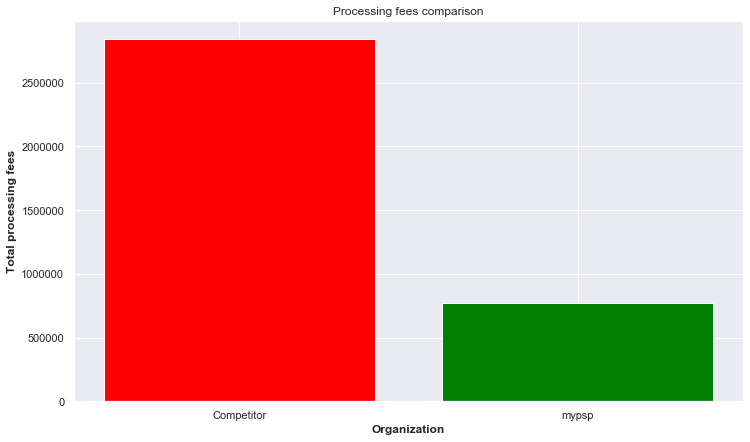

In [36]:
# Visualize the processing fees through Bar plot
plt.figure(figsize=(12,7))
plt.bar(["Competitor", "mypsp"], [prev_total_processing_fee, mypsp_total_processing_fee], color = ("red", "green"))
plt.xlabel("Organization", fontweight='bold')
plt.ylabel("Total processing fees", fontweight='bold')
plt.title("Processing fees comparison")
plt.show()

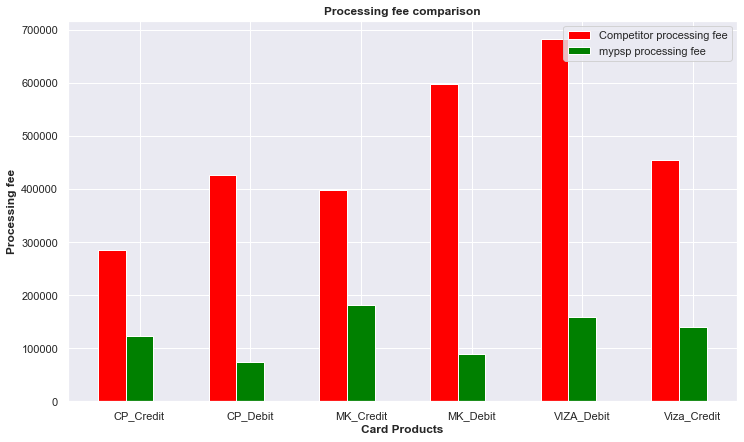

In [37]:
plt.figure(figsize=(12,7))

# set width of bar
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(prev_processing_fee_card_product_list))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, prev_processing_fee_card_product_list, color="red", width=barWidth, label='Competitor processing fee')
plt.bar(r2, mypsp_processing_fee_card_product_list, color="green", width=barWidth, label='mypsp processing fee')
 
# Add xticks on the middle of the group bars
plt.xlabel('Card Products', fontweight='bold')
plt.ylabel('Processing fee', fontweight='bold')
plt.title("Processing fee comparison", fontweight='bold')
plt.xticks([r + barWidth for r in range(len(card_products))], card_products)
 
# Create legend & Show graphic
plt.legend(loc = "upper right")
plt.show()

## Question 4: product

Based on what you've learned so far, come up with the next project My_PSP should build.

Make sure to include:
* A revenue estimate
* Why it's relevant
* Initial specification of which stages/how we're going to tackle this, keep in mind dev resources are not relevant.

There's no right or wrong answer. Surprise me!